In [281]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import skimage as sk
import skimage.io as skio
import skimage.transform as sktr
import os
import time
from scipy.ndimage.filters import gaussian_filter

# Crop image
def crop(img, ratio=0.2):
    h, w = np.floor(np.multiply(img.shape, ratio)).astype(int)
    return img[h:-h, w:-w]


# SSD method
def SSD_loss(a, b):
    loss = np.sum((a - b)**2)
    return loss


# NCC method
def NCC_loss(a, b):
    lossV = np.correlate((a / np.linalg.norm(a)).flatten(),
                         (b / np.linalg.norm(b)).flatten(), 'full')
    loss = np.sum(lossV)
    return loss


# trim the area that rgb channels not share the content
def trim_rgb(img, shift_r, shift_g):
    x_left = max(shift_r[0], shift_g[0], 0)
    x_right = min(shift_r[0], shift_g[0], -1)
    y_up = max(shift_r[1], shift_g[1], 0)
    y_down = min(shift_r[1], shift_g[1], -1)
    img = img[x_left:x_right, y_up:y_down, :]
    return img


def contrast(img):
    r, g, b = img[:, :, 0], img[:, :, 1], img[:, :, 2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    histogram = gray.copy().flatten()
    histogram.sort()
    p1 = histogram[int(histogram.shape[0] * 0.05)]
    p2 = histogram[int(histogram.shape[0] * 0.95)]
    ha = 255 / (p2 - p1)
    hb = -255 * p1 / (p2 - p1)
    print(p1, p2, ha, hb)
    img = img * ha + hb

    img[img < 0] = 0
    img[img > 255] = 255
    img = np.uint8(img)
    #     print(img)
    return img


def USM(img):
    blur_kernel = 7
    threshold = 0
    amp = 1500
    if (img.ndim == 3):
        blur = gaussian_filter(img, sigma=(blur_kernel, blur_kernel, 0))
    if (img.ndim == 2):
        blur = gaussian_filter(img, sigma=(blur_kernel, blur_kernel))
    diff = img - blur
    img[diff > threshold] -= diff[diff > threshold] * amp / 100
    return img


# align function
def align(target, ref, center=np.array([0, 0]), search=np.array([15, 15])):
    target_crop = crop(target)
    ref_crop = crop(ref)
    loss_min = float('inf')
    shift = np.array([0, 0])
    for i in range(-search[0] + center[0], search[0] + center[0] + 1):
        for j in range(-search[1] + center[1], search[1] + center[1] + 1):
            target_shift = np.roll(target_crop, i, axis=0)
            target_shift = np.roll(target_shift, j, axis=1)
            # loss function
            loss = SSD_loss(target_shift, ref_crop)
            if (loss < loss_min):
                loss_min = loss
                shift = np.array([i, j])
    target_final = np.roll(target, shift[0], axis=0)
    target_final = np.roll(target_final, shift[1], axis=1)
    return target_final, shift


# pyramid
def pyramid(target, ref):
    base = 2
    layer_start = 7  #start from min dimension of 128
    layer_end = 0
    shift = np.array([0, 0])
    search = np.array([15, 15])
    # take log2 to decide number of scales
    scale_total = np.floor(np.log(min(target.shape)) /
                           np.log(base)).astype(int)
    # do not use pyramid if image is smaller than 512*512
    if (scale_total < 9):
        target_temp, shift = align(target, ref, center=shift, search=search)
        print("image is smaller than 512*512, not use pyramid")
        return target_temp, shift

    print("The pyramid of downsampling has " + str(scale_total + 1) +
          " layers")
    print("Start from layer " + str(layer_start + 1))

    for scale in range(scale_total - layer_start, layer_end - 1, -1):
        print("Calculate the layer of " + str(scale_total - scale + 1))
        # start from the top of the pyramid(minimum size of image)
        target_scaled = sk.transform.rescale(target,
                                             1 / base**scale,
                                             anti_aliasing=True)
        ref_scaled = sk.transform.rescale(ref,
                                          1 / base**scale,
                                          anti_aliasing=True)
        # use USM to sharp edge
        target_scaled = USM(target_scaled)
        ref_scaled = USM(ref_scaled)
        # align in current layer of pyramid
        target_temp, shift = align(target_scaled,
                                   ref_scaled,
                                   center=shift,
                                   search=search)
        search -= 2
        shift = shift * base

    shift = (shift * (base**(layer_end - 1))).astype(int)
    target_final = np.roll(target, shift[0], axis=0)
    target_final = np.roll(target_final, shift[1], axis=1)

    return target_final, shift


# trim the border with high mean square difference
def trim_border(img):
    threshold = 0.019
    drift = 0
    r, g, b = img[:, :, 0], img[:, :, 1], img[:, :, 2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    # row
    mean_row = ((gray - gray.mean(1, keepdims=True))**2).mean(1, keepdims=True)
    row_up = np.roll(mean_row, -1, axis=0)
    row_up[-1, :] = mean_row[-1, :]
    row_down = np.roll(mean_row, 1, axis=0)
    row_down[0, :] = mean_row[0, :]
    #     mean_row = (mean_row + row_up + row_down) / 3
    index_row = np.argwhere(
        (mean_row > threshold) * (row_up > threshold) * (row_down > threshold))
    gray = gray[index_row[0 + drift, 0]:index_row[-1 - drift, 0], :]

    # col
    mean_col = ((gray - gray.mean(0, keepdims=True))**2).mean(0, keepdims=True)
    #     print(mean_col.shape)
    col_left = np.roll(mean_col, -1, axis=1)
    col_left[:, -1] = mean_col[:, -1]
    col_right = np.roll(mean_col, 1, axis=1)
    col_right[:, 0] = mean_col[:, 0]
    #     mean_col = (mean_col + col_right + col_left) / 3
    index_col = np.argwhere((mean_col > threshold) * (col_left > threshold) *
                            (col_right > threshold))
    gray = gray[:, index_col[0 + drift, 1]:index_col[-1 - drift, 1]]
    # color image trim
    img = img[index_row[0 + drift, 0]:index_row[-1 - drift, 0], :]
    img = img[:, index_col[0 + drift, 1]:index_col[-1 - drift, 1]]

    return img

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Crop image


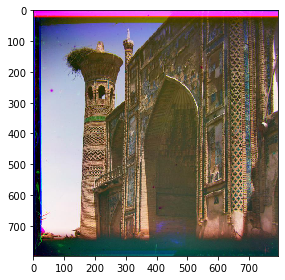

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Crop image


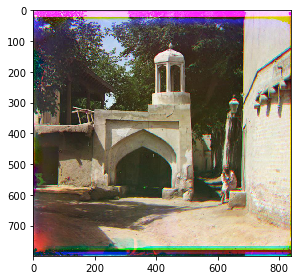

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Crop image


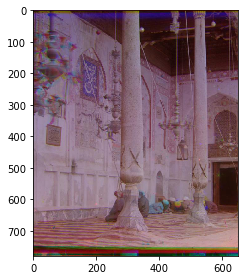

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Crop image


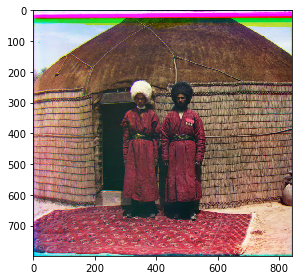

In [276]:
# align the images
# functions that might be useful for aligning the images include:
# np.roll, np.sum, sk.transform.rescale (for multiscale)

# name of the input file
file_list = os.listdir('./output/outdata')
for file_name in file_list:
    imname = "./output/outdata/" + file_name
    # read in the image
    im = skio.imread(imname)
    # convert to double (might want to do this later on to save memory)
    im = sk.img_as_float(im)
#     # compute the height of each part (just 1/3 of total)
#     height = np.floor(im.shape[0] / 3.0).astype(int)
#     # separate color channels
#     b = im[:height]
#     g = im[height:2 * height]
#     r = im[2 * height:3 * height]

#     print("Processing image" + file_name)
#     start = time.time()
#     # ag,shift = align(g, b)
#     # ar,shift = align(r, b)
#     print("align g to b")
#     ag, shift_ag = pyramid(g, b)
#     print("align r to b")
#     ar, shift_ar = pyramid(r, b)
#     print("The time of execution of above program is :", time.time() - start)
#     # create a color image
#     im_out = np.uint8(np.dstack([ar, ag, b]) * 255)
    # crop image
    print("Crop image")
    im_out = im
    im_out = trim_border(im_out)
    #     im_out = trim_rgb(im_out, shift_ar, shift_ag)
    # add contrast
#     print("Add contrast")
#     im_out = contrast(im_out)
    # save the image
    size = min(im_out.shape[0], im_out.shape[1])
    if (size > 512):
        scale = np.floor(np.log2(size) - np.log2(512)).astype(int)
        im_out = sk.transform.rescale(im_out, (1 / 2**scale, 1 / 2**scale, 1))
    jpgname = file_name.replace(".tif", ".jpg")
    fname = './output/outdata_crop/' + jpgname
    skio.imsave(fname, im_out)

    # display the image
    skio.imshow(im_out)
    skio.show()

align g to b
The pyramid of downsampling has 12 layers
Start from layer 8
Calculate the layer of 8
Calculate the layer of 9
Calculate the layer of 10
Calculate the layer of 11
Calculate the layer of 12
align r to b
The pyramid of downsampling has 12 layers
Start from layer 8
Calculate the layer of 8
Calculate the layer of 9
Calculate the layer of 10
Calculate the layer of 11
Calculate the layer of 12
The time of execution of above program is : 55.51749038696289


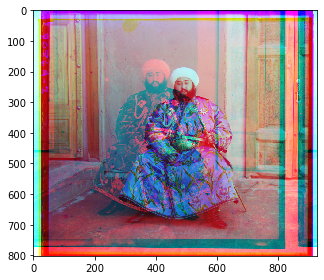

In [282]:
# name of the input file
file_list = os.listdir('./data')
file_number = 1
imname = "./data/" + file_list[file_number]
# read in the image
im = skio.imread(imname)
# convert to double (might want to do this later on to save memory)
im = sk.img_as_float(im)
# compute the height of each part (just 1/3 of total)
height = np.floor(im.shape[0] / 3.0).astype(int)
# separate color channels
b = im[:height]
g = im[height:2 * height]
r = im[2 * height:3 * height]
start = time.time()
print("align g to b")
ag, shift_ag = pyramid(g, b)
print("align r to b")
ar, shift_ar = pyramid(r, b)
print("The time of execution of above program is :", time.time() - start)
# create a color image
im_out = np.uint8(np.dstack([ar, ag, b]) * 255)

# crop image
# print("Crop image")
# im_out = im
# im_out = trim_rgb(im_out, shift_ar, shift_ag)
# for i in range(5):
#     im_out = trim_border(im_out)

# add contrast
# im_out = USM(im_out)
# im_out = contrast(im_out)
# save the image
size = min(im_out.shape[0],im_out.shape[1])
if(size>512):
    scale = np.floor(np.log2(size)-np.log2(512)).astype(int)
    im_out = sk.transform.rescale(im_out,(1/2**scale,1/2**scale,1))
im_out = np.uint8(im_out*255)
# im_out = np.uint8(im_out)
jpgname = file_list[file_number].replace(".tif", ".jpg")
fname = './output/pyramid/' + jpgname
skio.imsave(fname, im_out)

# display the image
skio.imshow(im_out)
skio.show()

Processing image00001a.tif
align g to b
The pyramid of downsampling has 12 layers
Start from layer 8
Calculate the layer of 8
Calculate the layer of 9
Calculate the layer of 10
Calculate the layer of 11
Calculate the layer of 12
align r to b
The pyramid of downsampling has 12 layers
Start from layer 8
Calculate the layer of 8
Calculate the layer of 9
Calculate the layer of 10
Calculate the layer of 11
Calculate the layer of 12
The time of execution of above program is : 58.535377502441406


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


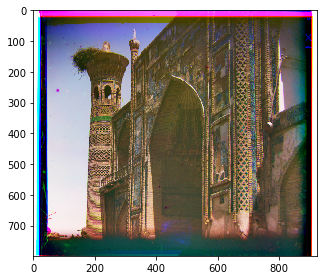

Processing image00002u.tif
align g to b
The pyramid of downsampling has 12 layers
Start from layer 8
Calculate the layer of 8
Calculate the layer of 9
Calculate the layer of 10
Calculate the layer of 11
Calculate the layer of 12
align r to b
The pyramid of downsampling has 12 layers
Start from layer 8
Calculate the layer of 8
Calculate the layer of 9
Calculate the layer of 10
Calculate the layer of 11
Calculate the layer of 12
The time of execution of above program is : 57.12356948852539


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


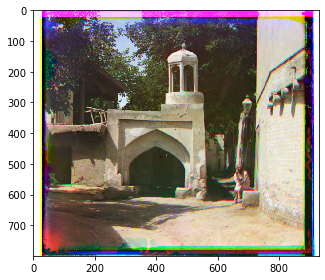

Processing image00004a.tif
align g to b
The pyramid of downsampling has 12 layers
Start from layer 8
Calculate the layer of 8
Calculate the layer of 9
Calculate the layer of 10
Calculate the layer of 11
Calculate the layer of 12
align r to b
The pyramid of downsampling has 12 layers
Start from layer 8
Calculate the layer of 8
Calculate the layer of 9
Calculate the layer of 10
Calculate the layer of 11
Calculate the layer of 12
The time of execution of above program is : 56.4737114906311


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


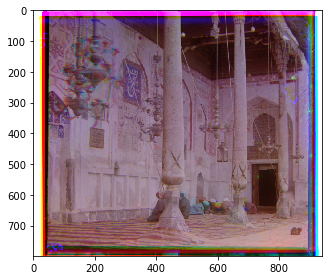

Processing image00005u.tif
align g to b
The pyramid of downsampling has 12 layers
Start from layer 8
Calculate the layer of 8
Calculate the layer of 9
Calculate the layer of 10
Calculate the layer of 11
Calculate the layer of 12
align r to b
The pyramid of downsampling has 12 layers
Start from layer 8
Calculate the layer of 8
Calculate the layer of 9
Calculate the layer of 10
Calculate the layer of 11
Calculate the layer of 12
The time of execution of above program is : 55.49748492240906


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


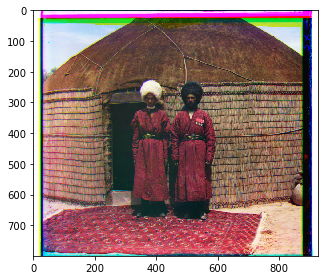

In [268]:
# align the images
# functions that might be useful for aligning the images include:
# np.roll, np.sum, sk.transform.rescale (for multiscale)

# name of the input file
file_list = os.listdir('./dataset_extra')
for file_name in file_list:
    imname = "./dataset_extra/" + file_name
    # read in the image
    im = skio.imread(imname)
    # convert to double (might want to do this later on to save memory)
    im = sk.img_as_float(im)
    # compute the height of each part (just 1/3 of total)
    height = np.floor(im.shape[0] / 3.0).astype(int)
    # separate color channels
    b = im[:height]
    g = im[height:2 * height]
    r = im[2 * height:3 * height]

    print("Processing image" + file_name)
    start = time.time()
    # ag,shift = align(g, b)
    # ar,shift = align(r, b)
    print("align g to b")
    ag, shift_ag = pyramid(g, b)
    print("align r to b")
    ar, shift_ar = pyramid(r, b)
    print("The time of execution of above program is :", time.time() - start)
    # create a color image
    im_out = np.uint8(np.dstack([ar, ag, b]) * 255)
    # save the image
    size = min(im_out.shape[0], im_out.shape[1])
    if (size > 512):
        scale = np.floor(np.log2(size) - np.log2(512)).astype(int)
        im_out = sk.transform.rescale(im_out, (1 / 2**scale, 1 / 2**scale, 1))
    jpgname = file_name.replace(".tif", ".jpg")
    fname = './output/outdata/' + jpgname
    skio.imsave(fname, im_out)

    # display the image
    skio.imshow(im_out)
    skio.show()

In [113]:
def aaa():
    a = 10
    b = 5
    return a, b


c, d = aaa()
a=np.array([[1,9],[3,4],[5,6]])
c= a.mean(0,keepdims=True)
print(a-c)

[[-2.          2.66666667]
 [ 0.         -2.33333333]
 [ 2.         -0.33333333]]
